In [113]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime
import time 

## Group Assignment
### Team Number: 01
### Team Member Names: Edward Huang, Emma Zhang, Naeem Moostofa
### Team Strategy Chosen: Market Beat 

AI Usage: 

ChatGPT was used to get documentation to create a pie chart to show the diversification of our portfolio. 

ChatGPT was used to help annualize weekly data since data from government bonds is already annualized. 

ChatGPT was used to create another sample list of tickers which was analyzed. 

### General Approach:

We used yfiance to extract stock data and filter data so that we are only considering stocks that are listed in Canada and the US. In order to create a portfolio to beat the market we chose to analyze the sharpe ratio and beta of our stocks. We combined these into a score for each stock where the score is calculated with the following formula: score = sharpe_ratio * 0.8 + beta * 0.2. These coefficients were determined by simulating our strategy which is discussed at the end. In order to create our final portfolio, we looked for stocks whose score was above a fixed threshold, ensuring that we had at least 12 stocks, no more than 24 stocks, and no industry is more than 20% of the portfolio. 

### Our Program:

#### Filtering Tickers: 


We can first read in the csv file:

In [114]:
file_name = "Tickers.csv"

csv = pd.read_csv(file_name)
col_name = "Ticker"
# in the csv file the name of the column is the first ticker so we can put that ticker at the end of the list and rename the column
csv.loc[len(csv)]= [csv.columns[0]]
csv.rename(columns={csv.columns[0] : col_name}, inplace=True)

display(csv.head())

,Ticker
0,AAPL
1,ABBV
2,LOW
3,AUST
4,HOOD


We can then filter the tickers so that we only look at stocks listed in Canada or the US and have a minimum average mounthly volume of 100,000. If there are invalid tickers an error message will appear underneath this block.  

In [115]:
# function that takes the csv file and filters the valid tickers 
valid_currency = ["USD","CAD"]
min_avg_mounthly_volume = 100_000
min_trading_days_per_mounth = 18
mounths = ["2023-10-31","2023-11-30","2023-12-31","2024-01-31","2024-02-29","2024-03-31",
           "2024-04-30","2024-05-31","2024-06-30","2024-07-31","2024-08-31","2024-9-30"]

# filter_tickers is a function that takes a dataframe of tickers and produces a new dataframe of valid tickers, their currency, and industry
def filter_tickers(tickers_df):
    valid_tickers = []
    valid_tickers_currency = []
    valid_tickers_industry = []
     
    for i in range(len (tickers_df)):
        num_mounths = 0
        volumes = []
        # this try-except block will ensure that the program does not produce an error if there is an invalid ticker and instead will skip that ticker
        try:  
            ticker = yf.Ticker(tickers_df.iloc[i,0])
            currency = ticker.fast_info["currency"]
            industry = ticker.info["industry"]
            
            # checks if the currency is CAD of USD
            if currency in valid_currency:
                # yf.download is used to get data since it is faster than yf.history 
                stock_data = yf.download(tickers_df.iloc[i,0], mounths[0], mounths[-1], progress=False)
                time.sleep(0.2)
                # counts how many trading days are in each mounth and gets the volume of trading in each mounth 
                for j in range(len(mounths) - 1):
                    start = mounths[j]
                    end = mounths[j + 1]

                    # gets the data for that mounth
                    data = stock_data[start:end][1:]

                    # get_num_trading_days_and_volume gets the number of valid trading days in the mounth, we check each mounth induvidually for each
                    # ticker since there may be some tickers that were only listed halfway through a mounth, and holidays may be different for canadian 
                    # us stocks 
                    num_days, volume = get_num_trading_days_and_volume(data)

                    if (num_days >= min_trading_days_per_mounth):
                        # add the volume to a list of all volumes 
                        volumes.append(volume)
                        num_mounths += 1

                # checks if the average mounthly volume is at least 100000 
                if (sum(volumes)/num_mounths >= min_avg_mounthly_volume):
                    valid_tickers.append(tickers_df.iloc[i,0])
                    valid_tickers_currency.append(currency)
                    valid_tickers_industry.append(industry)

        except Exception as e:
            pass
            
    # creates a new stock data frame with the filtered tickers, currency, and industry 
    df = pd.DataFrame({"Ticker":valid_tickers,"Currency":valid_tickers_currency, "industry":valid_tickers_industry})
    
    return df
      

# the function get_num_trading_days_and_volume gets the number of trading days and volume in the data
def get_num_trading_days_and_volume(data):
    volume = sum(data.Volume)
    return len(data), volume

Using the two functions above to filter the csv file: 

In [116]:
filtered_tickers = filter_tickers(csv)
display(filtered_tickers.head())

$INVALIDTIC: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$HDFC.NS: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$CELG: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")

1 Failed download:
['AW.TO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2023-10-31 -> 2024-9-30) (Yahoo error = "Data doesn\'t exist for startDate = 1698724800, endDate = 1727668800")')
$ASDFAASDF.TO: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")


,Ticker,Currency,industry
0,AAPL,USD,Consumer Electronics
1,ABBV,USD,Drug Manufacturers - General
2,LOW,USD,Home Improvement Retail
3,AUST,USD,Gold
4,HOOD,USD,Capital Markets


#### Calculating Ticker Scores: 



In order to analize the stocks we used sharpe ratio and beta whose formulas are given below:

\begin{align*}
\text{Sharpe Ratio} = \frac{\text{Portfolio Return} - \text{Risk Free Rate}}{\sigma_p}
\end{align*}

\begin{align*}
\beta=\frac{COV(x_i,r_M)}{\sigma^2(r_M)}
\end{align*}

For US stocks we will be using the IEF ticker which is 10 year US government bonds as the risk free rate. 

For Canadian stocks we will be using the XBB.TO ticker as the risk free rate, which an ETF that tracks Canadian government bonds. 



\
Since we are designing a program to beat the market, we want to include stocks that have a high Sharpe ratio—stocks that have a high return for the lowest risk, and stocks that have a higher beta since if we are taking on more risk than the market, we should be compensated. 

We can use the two functions below to calculate the sharpe ratio for every stock in `filtered_tickers`. If there is a ticker that was delisted between $\text{2024-9-30}$ and $\text{2024-11-20}$ an error message will be raised, and the stock will be dropped. We have chosen to use 3 years of historical data weekly to balance the computing time and amount of data. Additionally, data from before 2020 may be skewed for some stocks due to COVID-19. 

In [117]:
# The function sharpeCalc takes in a dataframe of tickers, a start date, and an end date and returns a dataframe with the sharpe ratio of each given ticker
def sharpeCalc(tickers, start_date, end_date):
    
    # U.S. T-Bonds and Calculate U.S. side risk free rate 
    UStbonds = yf.download('IEF', start=start_date, end=end_date, interval='5d', progress=False)['Adj Close'].pct_change().dropna()
    USRiskFreeRate = UStbonds.mean()

    # Canadian T-Bonds and Calculate Canadian side risk free rate 
    CADtbonds = yf.download('XBB.TO', start=start_date, end=end_date, interval='5d', progress=False)['Adj Close'].pct_change().dropna()
    CADRiskFreeRate = CADtbonds.mean()

    # DataFrame to store calculated Sharpe Ratios
    sharpe_ratios = []

    # Calculate Sharpe Ratio for each ticker
    for i in range(len(tickers)):

        # Download weekly Close price data for the i-th stock ticker
        stock_data = yf.download(tickers.Ticker.iloc[i], start=start_date, end=end_date, interval='5d', progress=False)['Adj Close'].pct_change().dropna()
        time.sleep(0.2)
        # if there was a dropped ticker it will have a value of nan and will be dropped later
        if stock_data.empty:
            sharpe_ratios.append(np.nan)
            continue 
            
        # Calculate annualized expected return and standard deviation
        expected_return = stock_data.mean() * 52
        std_dev = stock_data.std() * (52 ** 0.5)

        # Determine the correct risk-free rate
        rf = USRiskFreeRate if tickers['Currency'].iloc[i] == "USD" else CADRiskFreeRate

        # Calculate Sharpe Ratio
        sharpe_ratio = (expected_return - rf) / std_dev 
        sharpe_ratios.append(sharpe_ratio)

    # Return as a DataFrame
    return pd.DataFrame(sharpe_ratios, columns=['Sharpe Ratio'])

# The function betaCalc takes in a dataframe of tickers, a start date, and an end date and returns a dataframe with the beta of each given ticker
def betaCalc(tickers, start_date, end_date):
    # Download weekly market index data
    # the ^GSPC ticker is for the s&p500 and the XIU.TO ticker is for the tsx60
    sp_data = yf.download('^GSPC', start=start_date, end=end_date, interval='5d', progress=False)['Adj Close'].pct_change().dropna()
    time.sleep(0.2)
    tsx_data = yf.download('XIU.TO', start=start_date, end=end_date, interval='5d', progress=False)['Adj Close'].pct_change().dropna()

    # Average the returns of the two indexes to represent the market
    market_data = pd.concat([sp_data, tsx_data], axis=1).mean(axis=1)

    # DataFrame to store calculated Betas
    betas = []

    # Calculate Beta for each ticker
    for i in range(len(tickers)):

        # Download weekly Close price data for the i-th stock ticker
        stock_data = yf.download(tickers['Ticker'].iloc[i], start=start_date, end=end_date, interval='5d', progress=False)['Close'].pct_change().dropna()
        time.sleep(0.2)
        # if there was a dropped ticker it will have a value of nan and will be dropped later
        if stock_data.empty:
            betas.append(np.nan)
            continue 
            
        # Combine stock and market data
        combined_data = pd.concat([stock_data, market_data], axis=1)
        combined_data.columns = ['Stock', 'Market']

        # Calculate covariance of stock and market returns
        covariance = combined_data.cov().iloc[0, 1]

        # Calculate variance of market returns
        market_variance = combined_data['Market'].var()

        # Calculate Beta
        beta = covariance / market_variance
        betas.append(beta)

    # Return as a DataFrame
    return pd.DataFrame(betas, columns=['Beta'])

Using the two functions to calculate the sharpe ratio and beta of the stocks:

In [118]:
start_date = "2021-01-01" 
end_date = "2024-11-22" 

# Makes a copy of the filtered_tickers data frame
tickers_sharpe_beta = filtered_tickers.copy(deep = True)

# Calculate the Sharpe Ratio and Beta for the list of stock tickers
tickers_sharpe_beta['Sharpe Ratio'] = sharpeCalc(tickers_sharpe_beta, start_date, end_date)
tickers_sharpe_beta['Beta'] = betaCalc(tickers_sharpe_beta, start_date, end_date)
# Drop any invalid stocks
tickers_sharpe_beta = tickers_sharpe_beta.dropna()
# NEW CODE
tickers_sharpe_beta.index = [i for i in range(len(tickers_sharpe_beta))]
# Display the updated DataFrame
display(tickers_sharpe_beta.head())

,Ticker,Currency,industry,Sharpe Ratio,Beta
0,AAPL,USD,Consumer Electronics,0.780148,1.252673
1,ABBV,USD,Drug Manufacturers - General,0.923000,0.102663
2,LOW,USD,Home Improvement Retail,0.717563,1.231371
3,AMZN,USD,Internet Retail,0.359080,1.674739
4,AXP,USD,Credit Services,0.971474,1.612559


The score for each stock is calculated by: Score = 0.8 * sharpe_ratio + 0.2 * beta. The scores are normalized and the dataframe is sorted by score.

In [119]:
# score_calculator calculates a score based for each stock based on the Sharpe Ratio and Beta given in the consumed dataframe.
# The Sharpe Ratio and Beta calculation is based on the consumed sharpe ratio weight and beta weight. 
# The function produces the same consumed dataframe with a new column containing the normalized combined score for each stock.
def score_calculator(df, sharpe_weight, beta_weight):

    # Creates series combined to store combined score
    combined = pd.Series(index=df.index)

    # Calculates combined score based on sharpe ratio weight and beta weight and places it in corresponding index in combined
    for i in range(len(df)):
        combined[i] = df["Sharpe Ratio"].iloc[i]*sharpe_weight + df["Beta"].iloc[i]*beta_weight

    # Creates series combined_norm to store normalized combined score
    combined_norm = pd.Series(index=combined.index)

    # Normalizes each combined score and stores them in the corresponding index in combined_norm
    for i in range(len(combined)):
        combined_norm[i]= (combined[i] - combined.min()) / (combined.max() - combined.min())
        
    # Adds combined_norm to the end of the dataframe with corresponding column name
    df = pd.concat([df, combined_norm], axis=1)
    df.columns = list(df.columns[:-1]) + ['Score']

    # Sorts dataframe based on combined_norm from highest score to lowest score
    df.sort_values(by="Score", ascending=False, inplace=True)
    df.index = [i for i in range(len(df))]

    # Returns the new dataframe
    return df

Applying the score calculator to our data frame: 

In [120]:
sharpe_weight = 0.8
beta_weight = 0.2

tickers_scores = tickers_sharpe_beta.copy(deep = True)
tickers_scores = score_calculator(tickers_scores, sharpe_weight, beta_weight)

display(tickers_scores.head())

,Ticker,Currency,industry,Sharpe Ratio,Beta,Score
0,COST,USD,Discount Stores,1.377991,0.958183,1.000000
1,COST,USD,Discount Stores,1.377991,0.958183,1.000000
2,ORCL,USD,Software - Infrastructure,1.175169,1.401726,0.939067
3,SPG,USD,REIT - Retail,1.098229,1.461634,0.897999
4,RY.TO,CAD,Banks - Diversified,1.177308,0.857815,0.850362


#### Portfolio Formation: 

In order to create a diversified portfolio from the `tickers_scores` data frame, we can first set a score threshold, which is the ideal minimum score that a stock in our portfolio should contain. Then, the percentage of the portfolio that each selected stock can be calculated by: % = $\frac{\text{score}}{\sum \text{scores}}$. This will ensure that the sum of all percentages is 100%. Then, in order to ensure that no stock is more than 15% or less than 100/2n% (where n is the number of stocks) of the portfolio, we can go through the stocks, shifting excess percentages over 15% to the stock below and taking the missing percentage for any stock that is less than 100/2n% from the stock above. This will ensure that the sum of all percentages is still 100%. Finally, in order to ensure that no single industry is more than 20% of the portfolio, a dictionary is created to keep track of the percentage of the amount in each industry, and if any industry has more than 20%, the stock with the smallest score from that industry is flagged, and we restart the process, only this time we do not consider stocks that have already been flagged.



By ensuring that no single industry contains more than 20% of our portfolio, we can diversify away the idiosyncratic risk of any one industry and will only be left with market risk in our portfolio 

In [121]:
# the ensure_diversification function checks if any industry in the df is more than the max_industry_percentage, if there is new percentages are 
# created with the portfolio without including any stocks that resulted in it going over the max_industry_percentage
def ensure_diversification(df, max_industry_percentage):
    industry_percentages = {}
    new_df = df.copy(deep = True)
    made_change = False

    for i in range(len(df)):
        industry = df.loc[i,"industry"]
        percentage = df.loc[i, "Weight"]

        # if the industry is already in the dictionary the percentage is added to the value, otherwise that industry is added as a new key in the 
        # dictionary
        if industry in industry_percentages.keys(): 
            industry_percentages[industry] += percentage
        else: 
             industry_percentages[industry] = percentage
    
    # iterates through the dataframe backwards since we want to remove stocks with the lowest score first 
    for i in range((len(new_df) - 1), -1, -1):
        industry = new_df.loc[i,"industry"]
        percentage = new_df.loc[i, "Weight"]

        # the percentage must be greater than 0 since if the percentage is 0 we are not considering that stock 
        if (percentage > 0 and industry_percentages[industry] > max_industry_percentage):
            new_df.at[i, "include_for_diversification"] = False
            industry_percentages[industry] -= percentage
            # since we have found a stock that should not be in the portfolio we should recreate the portfolio without that stock
            made_change = True

    if (not made_change):
        return new_df
    else:
        return add_percentages(new_df, max_num_stocks, min_num_stocks, max_percentage)

# the calculate_min_percentage function produces the minimum percentance that a stock can contain in the portfolio where 
# min% = 100/2n %
def calculate_min_percentage(num_stocks):
    return 1 / (2 * num_stocks)

# the check_percentanges function takes the dataframe df, with the percent of the portfolio that each stock has and ensure that no stock is more than 
# the max_percentage and no stock is less than the value of the calculate_min_percentage function 
def check_percentanges(df, max_percentage, num_stocks):
    min_percentage = calculate_min_percentage(num_stocks)

    new_df = df.copy(deep = True)

    # check if any stocks have more than the max_percentage
    for i in range(len(df)):
        percentage = new_df.loc[i,"Weight"]

        if (percentage > max_percentage):
            new_df.at[i,"Weight"] = max_percentage
            # give the excess percentage to the next stock
            new_df.at[i + 1,"Weight"] += percentage - max_percentage

    # loop through the data frame backwards to check if any stocks have less than the min percentage 
    for i in range(len(df) - 1, -1, -1):
        percentage = new_df.loc[i,"Weight"]

        # the percentage must be greater than 0 to be in the portfolio 
        if 0 < percentage < min_percentage:  
            amount_needed = min_percentage - percentage

            new_df.at[i, "Weight"] = min_percentage
            # take the amount needed to meet the min_percentage from the stock above in the data frame 
            new_df.at[i - 1, "Weight"] -= amount_needed

    # ensure that the new data frame with balanced percenteages is diversified 
    return ensure_diversification(new_df, max_industry_percentage)

def add_percentages(df, max_num_stocks, min_num_stocks, max_percentage):
    valid_scores = []
    num_stocks = 0

    for i in range(len(df)): 
        score = df.loc[i, "Score"]
        # indicates whether a stock should be ommited to ensure we have a diversified portfolio 
        allowed_diverse = df.loc[i, "include_for_diversification"]

        # will keep including stocks if we are not at the min_num_stocks or we are less than the max_num_stocks and have a score above the 
        # min_score threshold 
        if (allowed_diverse and num_stocks < max_num_stocks and (num_stocks < min_num_stocks or score >= min_score)):  
            valid_scores.append(score)
            num_stocks += 1
        else:
            # if a stock is not given a percentage is have a weight of 0
            valid_scores.append(0)

    sum_scores = sum(valid_scores)

    # uses the forumla discuessed above to calculate the percentage that each stock should recieve 
    sum_one_scores = [i/sum_scores for i in valid_scores]

    new_df = df.copy(deep = True)

    new_df["Weight"] = sum_one_scores

    # ensures that the weights in the data frame fall within an acceptable range 
    return check_percentanges(new_df, max_percentage, num_stocks)

In [122]:
min_num_stocks = 12
max_num_stocks = 24
min_score = 0.6 
max_percentage = 0.15
max_industry_percentage = 0.2

tickers_weights = tickers_scores.copy(deep = True)

# add a col called include_for_diversification - initally all T, indicates whether we are excluding stocks for diversification  
tickers_weights["include_for_diversification"] = True

tickers_weights = add_percentages(tickers_weights, max_num_stocks, min_num_stocks, max_percentage)
# filter out stocks removed to diversify 
stocks_removed_to_diversify = tickers_weights[tickers_weights["include_for_diversification"] == False]
stocks_removed_to_diversify = stocks_removed_to_diversify.drop("include_for_diversification", axis='columns')
stocks_removed_to_diversify.index = [i for i in range(len (stocks_removed_to_diversify))]

# filter stocks that we selected from tickers_weights
tickers_weights = tickers_weights[tickers_weights["Weight"] > 0]
tickers_weights = tickers_weights.drop("include_for_diversification", axis='columns')
tickers_weights.index = [i for i in range(len (tickers_weights))]

display(tickers_weights)

,Ticker,Currency,industry,Sharpe Ratio,Beta,Score,Weight
0,COST,USD,Discount Stores,1.377991,0.958183,1.000000,0.109128
1,ORCL,USD,Software - Infrastructure,1.175169,1.401726,0.939067,0.102478
2,SPG,USD,REIT - Retail,1.098229,1.461634,0.897999,0.097997
3,RY.TO,CAD,Banks - Diversified,1.177308,0.857815,0.850362,0.092798
4,AXP,USD,Credit Services,0.971474,1.612559,0.838996,0.091558
5,JPM,USD,Banks - Diversified,0.914249,1.265588,0.743578,0.081145
6,IBM,USD,Information Technology Services,1.021833,0.717014,0.723987,0.079007
7,OXY,USD,Oil & Gas E&P,0.847075,1.050431,0.663407,0.072396
8,GOOG,USD,Internet Content & Information,0.833656,1.054113,0.655123,0.071492
9,AAPL,USD,Consumer Electronics,0.780148,1.252673,0.652559,0.071212


In [123]:
if (len (stocks_removed_to_diversify) == 0):
    print("No stocks were excluded for diversification.")
else:
    print("The following stocks were to ensure diversification:")
    display(stocks_removed_to_diversify)

The following stocks were to ensure diversification:


,Ticker,Currency,industry,Sharpe Ratio,Beta,Score,Weight
0,COST,USD,Discount Stores,1.377991,0.958183,1.000000,0.0
1,BK,USD,Banks - Diversified,0.886888,1.194243,0.713622,0.0


The diversification of the portfolio can be visualized by creating a pie chart for each industry.  

,Industry,Percentage
0,Discount Stores,10.91
1,Software - Infrastructure,10.25
2,REIT - Retail,9.80
3,Banks - Diversified,17.39
4,Credit Services,9.16
5,Information Technology Services,7.90
6,Oil & Gas E&P,7.24
7,Internet Content & Information,7.15
8,Consumer Electronics,7.12
9,Home Improvement Retail,6.63


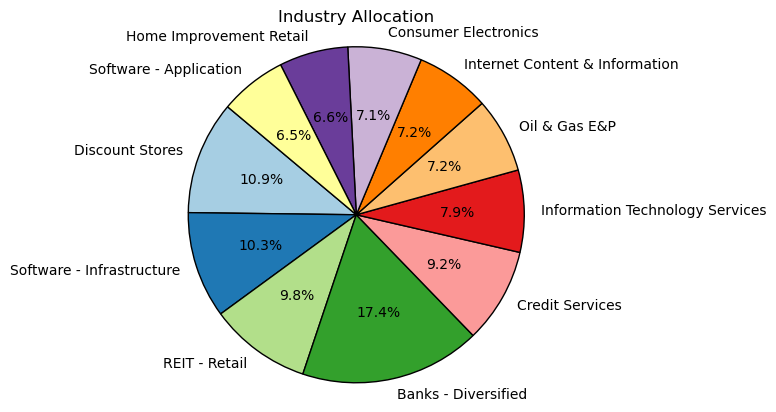

In [124]:
# industry_weight displays a dataframe with the weight of each industry for the stocks in the portfolio, and displays a piechart 
# with the weights of each industry

def industry_weight(df):

    #Find and Store the weight of each industry in a Dictionary called industry_chart
    industry_chart = {} 
    for i in range(len(df)):
        industry_chart[df["industry"].iloc[i]] = industry_chart.get(df["industry"].iloc[i], 0) + df["Weight"].iloc[i]*100

    #Round the percentages in industry_chart to two decimal points each
    industry_chart = {industry: round(percentage, 2) for industry, percentage in industry_chart.items()}

    #Convert the industry_chart dictionary into a DataFrame 
    industry_df = pd.DataFrame(list(industry_chart.items()), columns=['Industry', 'Percentage'])

    ## Display the Dataframe as one of our outputs
    display(industry_df)

    ## Create PieChart Using Dataframe
    labels = industry_df['Industry'] 
    sizes = industry_df['Percentage'] 
    colors = plt.cm.Paired.colors[:len(industry_df)]
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'black'})
    ax.axis('equal')

    plt.title('Industry Allocation')
    plt.show()

industry_weight(tickers_weights)

Now that we have the percentages and the stocks for our portfolio we can determine the number of shares of each stock that will be bought.  

In [125]:

# stock_chooser calculates four things and adds them to the end of the original dataframe. 
# 1. the total money spent on each stock 
# 2. the amount of shares owned in each stock using the closing price on the particular buy date
# 3. the total value of those shares after fees
# 4. the price of the stock on purchase
# Note: stock_chooser changes all stocks whose prices are in USD to CAD using the conversion rate from the day the stocks were bought.
#       All produced values are in CAD
# stock_chooser calculates this using each stock's given "Weight" from the consumed dataframe

def stock_chooser(df, buy_date):
        
    # Find the exchange rate of usd to cad on the buy date
    CADUSD = yf.Ticker("CADUSD=x")
    usd_to_cad = CADUSD.history(start=buy_date)    
    exchange_rate = usd_to_cad.Close.iloc[0]

    # Not adding the new columns onto the dataframe if they already exist
    if "Money Pre Fees" in df.columns:
        return df

    # Create Series to store total cost spent on stocks, value of stocks, number of shares, and price of stock on purchase
    stock_total_cost = pd.Series(index=df.index)
    stock_total_cost_after_fees = pd.Series(index=df.index)
    stock_shares = pd.Series(index=df.index)
    stock_buy_price = pd.Series(index=df.index)


    # Calculate the total cost spent on stocks, value of stocks, number of shares bought, and price for each share at pruchase
    # for each ticker and place in the corresponding location in the series

    for i in range(len(df)):

        # Find Closing Price of the stock on that particular day
        stock_ticker = yf.Ticker(df["Ticker"].iloc[i])
        stock_data = stock_ticker.history(start=buy_date)
        stock_price = stock_data["Close"].iloc[0]

        # Convert the price to CAD if stocks trades in USD
        if df["Currency"].iloc[i] == "USD":
            stock_price = stock_price / exchange_rate

        # Calculate total amount of money spent on a particular stock
        stock_money = df["Weight"].iloc[i] * 1000000

        # Calculate cost fees 
        per_share_fee = 0.001 * (stock_money / stock_price)
        flat_fee = 3.95

        ## Calculate price of stock at purchase and assign to Series
        stock_buy_price[i] = stock_price
        
        # Calculate total shares that can be bought and assign to Series
        stock_shares.iloc[i] = (stock_money - min(per_share_fee, flat_fee)) / stock_price

        # Assign total amount of money spent on a particular stock to corresponding Series
        stock_total_cost.iloc[i] = stock_money

        # Calculate total value of stocks and assign to Series
        stock_total_cost_after_fees.iloc[i] = stock_money - min(per_share_fee, flat_fee)

    # Add all three series to the end of the dataframe with the corresponding column title
    df = pd.concat([df, stock_buy_price], axis=1)
    df.columns = list(df.columns[:-1]) + ['Price']
    
    df = pd.concat([df, stock_total_cost], axis=1)
    df.columns = list(df.columns[:-1]) + ['Value before fees']

    df = pd.concat([df, stock_total_cost_after_fees], axis=1)
    df.columns = list(df.columns[:-1]) + ['Value']

    df = pd.concat([df, stock_shares], axis=1)
    df.columns = list(df.columns[:-1]) + ['Shares']
    
    return df

In [126]:
buy_date = "2024-11-22"

ticker_shares = tickers_weights.copy(deep = True)

ticker_shares = stock_chooser(ticker_shares, buy_date)

display(ticker_shares.head())

,Ticker,Currency,industry,Sharpe Ratio,Beta,Score,Weight,Price,Value before fees,Value,Shares
0,COST,USD,Discount Stores,1.377991,0.958183,1.000000,0.109128,1347.685973,109127.720106,109127.639131,80.974085
1,ORCL,USD,Software - Infrastructure,1.175169,1.401726,0.939067,0.102478,268.821406,102478.236293,102477.855080,381.211662
2,SPG,USD,REIT - Retail,1.098229,1.461634,0.897999,0.097997,253.233715,97996.577292,97996.190311,386.979239
3,RY.TO,CAD,Banks - Diversified,1.177308,0.857815,0.850362,0.092798,174.710007,92798.037206,92797.506052,531.151637
4,AXP,USD,Credit Services,0.971474,1.612559,0.838996,0.091558,421.217376,91557.768206,91557.550841,217.364135


#### Portfolio Simulation: 

In order to evaluate the performance of our portfolio and determine optimal sharpe and beta coefficients, we simulated the performance of a portfolio chosen using our strategy from 2014-2024, where the program only looks at data from 2011-2014 when determining which stocks to choose. In order to evaluate the performance of our portfolios, we will look at the performance of the market in that time period and a random, equally weighted portfolio with 25 stocks in the same time period. Since this simulation essentially runs our entire program multiple times, it will be very time-consuming and will take multiple minutes, so we have included images of graphs produced from this program, which will only run if the `RUN_CODE` variable is made True. 

In [127]:
RUN_CODE = False

stock_data_start = "2011-01-01"
start_simulation_date = "2014-01-01"
end_date = "2024-01-01"

market_ticker1 = "^GSPC"
market_ticker2 = "XIU.TO"

# the sharpe weights range from 0-1, the sum of the sharpe and beta weights will be 1
sharpe_weights = np.linspace(0.2, 1, 4, False)
beta_weights = 1 - sharpe_weights

# simulate_program simulates how portfolios with sharpe_weights and beta_weights which are selected by our program would perform if given data from 
# stock_data_start to start_simulation_date and are simulated from start_simulation_date to end_date. it returns each portfolio as % returns
def simulate_program(filterd_tickers, sharpe_weights, beta_weights, stock_data_start, start_simulation_date, end_date): 
    portfolios = []

    # the exchange rate is kept constant because in this time period the exchange rate changes by 20%, inflating the portfolio returns 
    CADUSD = yf.Ticker("CADUSD=x")
    cad_to_usd = CADUSD.history(start=start_simulation_date) 
    exchange_rate = cad_to_usd.Close.iloc[0]
        
    for i in range (len (sharpe_weights)):
        portfolio = filterd_tickers.copy(deep = True)

        # calculates the sharpe ratio and beta for all stocks in the portfolio       
        portfolio['Sharpe Ratio'] = sharpeCalc(portfolio, stock_data_start, start_simulation_date)
        portfolio['Beta'] = betaCalc(portfolio, stock_data_start, start_simulation_date)
        
        portfolio = score_calculator(portfolio, sharpe_weights[i], beta_weights[i]) 

        portfolio["include_for_diversification"] = True
        portfolio = add_percentages(portfolio, max_num_stocks, min_num_stocks, max_percentage)

        # filters out stocks that were not selected 
        portfolio = portfolio[portfolio["Weight"] > 0]
        portfolio = portfolio.drop("include_for_diversification", axis='columns')
        # reindexing the data frame 
        portfolio.index = [index for index in range(len (portfolio))]

        portfolio = stock_chooser(portfolio, start_simulation_date)
        # there are 120 mounths in the time period we are looking at 
        portfolio_over_time = np.zeros(120)
        
        for j in range(len(portfolio)):
            stock_data = yf.download(portfolio.loc[j, "Ticker"], start = start_simulation_date, end = end_date, interval = "1mo", progress = False)["Adj Close"].to_numpy()

            # if the stock is in USD it is converted 
            if portfolio.loc[j, "Currency"] == "USD":
                stock_data *= portfolio.loc[j, "Shares"] / exchange_rate 
            else: 
                stock_data *= portfolio.loc[j, "Shares"]
    
            # adds the value for that stock to the portfolio_over_time
            portfolio_over_time += stock_data
            
        # convert to % returns
        portfolio_over_time = (portfolio_over_time - portfolio_over_time[0]) / portfolio_over_time[0]
        
        portfolios.append(portfolio_over_time)
    
    return portfolios

# gets the average returns of market_ticker1 and market_ticker1 from the start_date to the end_date and the mounths in that time period
def get_market_data(market_ticker1, market_ticker2, start_simulation_date, end_date):
    
    money = 1_000_000
    # gets the market data for each ticker
    data1 = yf.download(market_ticker1, start = start_simulation_date, end = end_date, interval = "1mo", progress = False)["Adj Close"].to_numpy()
    data2 = yf.download(market_ticker2, start = start_simulation_date, end = end_date, interval = "1mo", progress = False)["Adj Close"].to_numpy()
    
    num_shares1 = money / data1[0]
    num_shares2 = money / data2[0]

    # gets the %returns for each 
    returns1 = ((data1 * num_shares1) - (data1 * num_shares1)[0]) / (data1 * num_shares1)[0]
    returns2 = ((data2 * num_shares2) - (data2 * num_shares2)[0]) / (data2 * num_shares2)[0]

    # takes an average of the % returns 
    return (returns1 + returns2) / 2

# the create_random_portfolio function creates a random equaly weighted portfolio containing the stocks in the filter_tickers dataframe 
def create_random_portfolio(filtered_tickers, num_stocks, start_simulation_date, end_date):
    # the exchange rate is kept constant because in this time period the exchange rate changes by 20%, inflating the portfolio returns 
    CADUSD = yf.Ticker("CADUSD=x")
    cad_to_usd = CADUSD.history(start=start_simulation_date) 
    exchange_rate = cad_to_usd.Close.iloc[0]
    
    tickers = filterd_tickers.sample(num_stocks)

    # reindexes the dataframe 
    tickers.index = [i for i in range(len (tickers))]
    
    rand_port = tickers.copy(deep = True)
    # stocks are equally weighted 
    rand_port["Weight"] = 1/num_stocks
    rand_port = stock_chooser(rand_port, start_simulation_date)
    
    rand_portfolio_over_time = np.zeros(120)
    
    for i in range(len (rand_port)):
        stock_data = yf.download(rand_port.loc[i, "Ticker"], start = start_simulation_date, end = end_date, interval = "1mo", progress = False)["Adj Close"].to_numpy()

        # if it is a USD stock convert it to CAD
        if (rand_port.loc[i, "Currency"] == "USD"):
            rand_portfolio_over_time += stock_data * rand_port.loc[i, "Shares"] / exchange_rate
    
        else:
            rand_portfolio_over_time += stock_data * rand_port.loc[i, "Shares"]

    # convert to % return
    rand_portfolio_over_time = (rand_portfolio_over_time - rand_portfolio_over_time[0])  / rand_portfolio_over_time[0]

    return rand_portfolio_over_time
    

if RUN_CODE:
    # since we are using a different date range the mounths for the filter_tickers function is changed
    mounths = ["2011-10-31","2011-11-30","2011-12-31","2012-01-31","2012-02-28","2012-03-31",
               "2012-04-30","2012-05-31","2012-06-30","2012-07-31","2012-08-31","2012-9-30"]
    
    filterd_tickers = filter_tickers(csv)
    portfolios = simulate_program(filterd_tickers, sharpe_weights, beta_weights, stock_data_start, start_simulation_date, end_date)  
    market = get_market_data(market_ticker1, market_ticker2, start_simulation_date, end_date)
    # the random portfolio will have 15 equally weighted stocks
    random_portfolio = create_random_portfolio(filtered_tickers, 15, start_simulation_date, end_date)

    for i in range(len(portfolios)):
        plt.plot(portfolios[i], label = "Sharpe weight: " + str(round(sharpe_weights[i],2)))
    
    plt.plot(market, label = "Market")
    plt.plot(random_portfolio, label = "Random")
    plt.title("Percent Reutrn of Portfolios from Tickers_Example.csv")
    plt.ylabel("Percent Return")
    plt.xlabel("Number of Mounths")
    plt.legend()
    plt.show()

Below is the a graph that was produced by the code above:

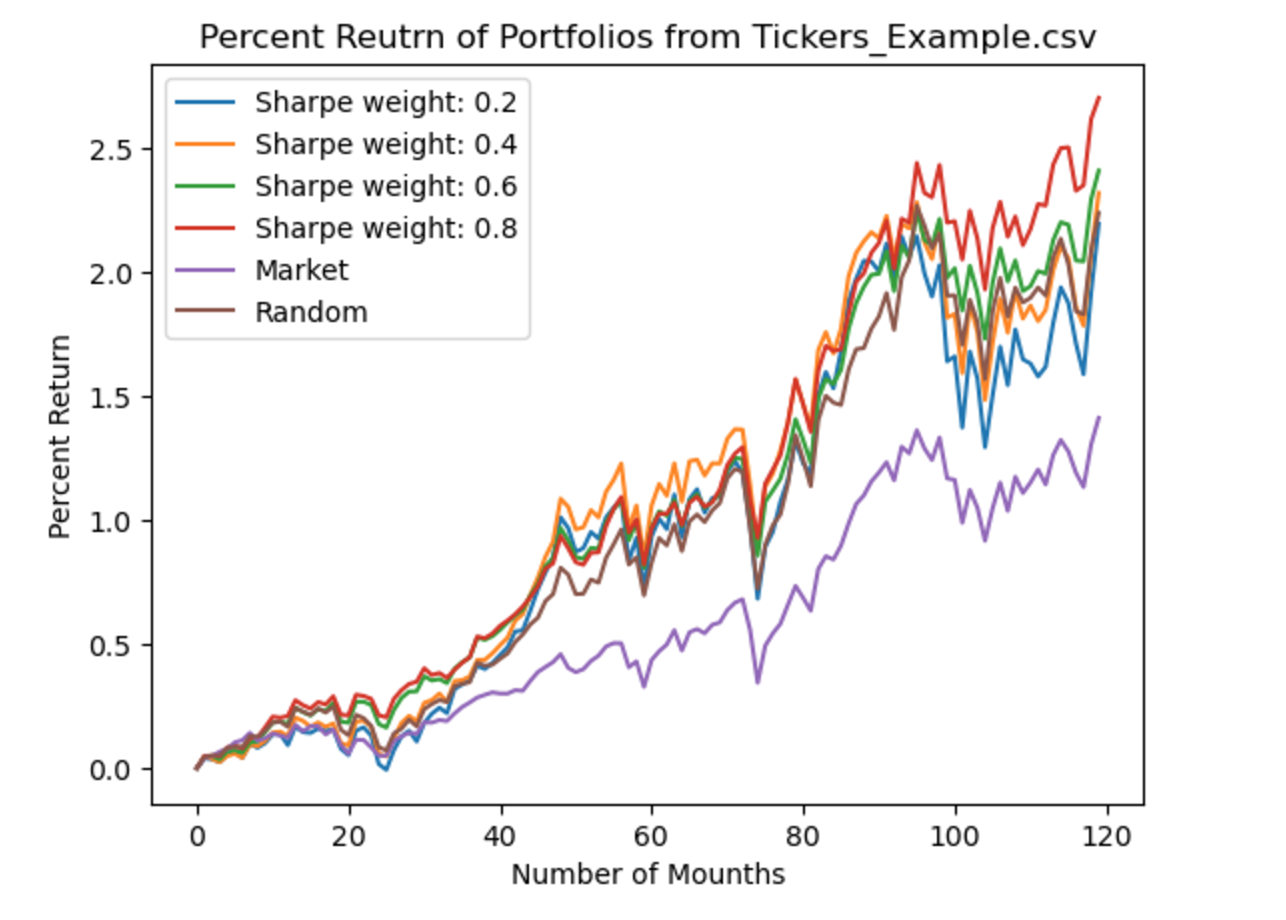


In the time period from 2014-2024, most stocks in the Tickers_Example.csv file outperformed the market, which can be highlighted by looking at the equally weighted random portfolio, which had a percent return of close to 2, while the market only had a percent return of under 1.5. In order to determine the optimal sharpe weight when calculating the score, we can compare the performance of the different portfolios to the randomly chosen portfolio. The portfolios with a sharpe weight of 0.2 and 0.4 perform very similarly to the random portfolios, while the portfolio with a sharpe ratio of 0.8 outperforms all other options. However, this was in an environment where a random portfolio would have been able to beat the market, in order to accurately evaluate the performance of the portfolios we used ChatGPT to create a new list of stocks, where for the same time period an average portfolio does not beat the market. Below is the code used to simulate these tickers; the `RUN_CODE` variable is used since running this code is very time-consuming.

In [128]:
RUN_CODE = False 

stock_data_start = "2011-01-01"
start_simulation_date = "2014-01-01"
end_date = "2024-01-01"

market_ticker1 = "^GSPC"
market_ticker2 = "XIU.TO"

# the sharpe weights range from 0-1, the sum of the sharpe and beta weights will be 1
sharpe_weights = np.linspace(0.2, 1, 4, False)
beta_weights = 1 - sharpe_weights

if RUN_CODE: 
    chat_gpt_tickers = [
    "BMO", "RY", "TD", "BNS", "CM", "ENB", "TRP", "SU", "CNQ", "BCE", 
    "TU", "CP", "CNI", "MFC", "PBA", "FNV", "GOLD", "CCJ", "TRI", "DOL.TO", 
    "MAG", "PAAS", "WFG", "WPM", "AEM", "AGI", "NGD", "IPL.TO", "VET.TO", 
    "H.TO", "CVE", "SLF", "BHC", "DOO.TO", "FTS", "EMA.TO", "BLDP", "WE.TO", 
    "X.TO", "OTEX", "ATA.TO", "NXE", "L.TO", "CIGI", "GOOS", "AC.TO", 
    "BAM.A.TO", "BIPC", "KEY.TO", "NA.TO", "WCN"
    ]

    tickers = pd.DataFrame({"Ticker" : chat_gpt_tickers})
    
    filterd_tickers = filter_tickers(tickers)
    portfolios = simulate_program(filterd_tickers, sharpe_weights, beta_weights, stock_data_start, start_simulation_date, end_date)  
    market = get_market_data(market_ticker1, market_ticker2, start_simulation_date, end_date)
    # the random portfolio will have 15 equally weighted stocks
    random_portfolio = create_random_portfolio(filtered_tickers, 15, start_simulation_date, end_date)

    for i in range(len(portfolios)):
        plt.plot(portfolios[i], label = "Sharpe weight: " + str(round(sharpe_weights[i],2)))
    
    plt.plot(market, label = "Market")
    plt.plot(random_portfolio, label = "Random")
    plt.title("Percent Reutrn of Portfolios from ChatGPT_Tickers.csv")
    plt.ylabel("Percent Return")
    plt.xlabel("Number of Mounths")
    plt.legend()
    plt.show()

Below is a graph that was produced from the code above: 


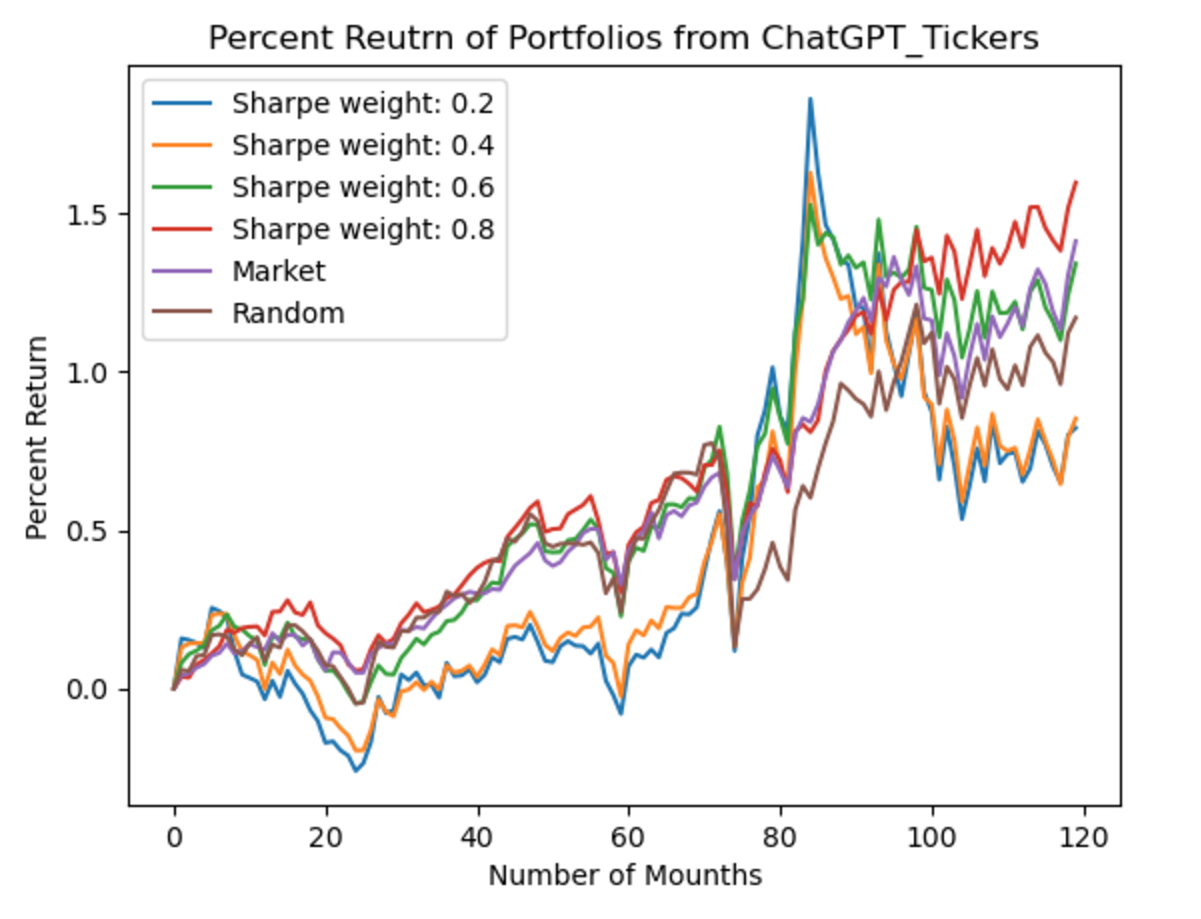

Here we can observe the performance of the different portfolios in an environment where most of the portfolios do not beat the market. Notably, around the 85-month mark, stocks with a lower sharpe weight spike and then rapidly decline. This was likely due to taking on more risk through a higher beta coefficient, however by the end of the time period the portfolio with a sharpe weight of 0.8 was the only one to outperform the market. In light of this analysis, we chose to use 0.8 as the sharpe weight in our program. 

#### Final Portfolio: 

In [129]:
Portfolio_Final = ticker_shares.copy(deep = True)
# drop unnecessary columns 
Portfolio_Final.drop(["industry", "Sharpe Ratio", "Beta", "Score", "Value before fees"], axis = 1, inplace = True)
# rearrange the columns
Portfolio_Final = Portfolio_Final[['Ticker', 'Price', 'Currency', 'Shares','Value', 'Weight']]
# reindex the portfolio so that it starts at 1
Portfolio_Final.index = [i for i in range(1, len(Portfolio_Final) + 1)]
display(Portfolio_Final)

,Ticker,Price,Currency,Shares,Value,Weight
1,COST,1347.685973,USD,80.974085,109127.639131,0.109128
2,ORCL,268.821406,USD,381.211662,102477.855080,0.102478
3,SPG,253.233715,USD,386.979239,97996.190311,0.097997
4,RY.TO,174.710007,CAD,531.151637,92797.506052,0.092798
5,AXP,421.217376,USD,217.364135,91557.550841,0.091558
6,JPM,347.472899,USD,233.528235,81144.732675,0.081145
7,IBM,311.712057,USD,253.460708,79006.758559,0.079007
8,OXY,72.598139,USD,997.203005,72395.082651,0.072396
9,GOOG,232.864867,USD,307.009533,71491.734065,0.071492
10,AAPL,321.358248,USD,221.597118,71212.061651,0.071212


We can show that the Weights add to 100% and the Values adds to 1000000:

In [130]:
weights = Portfolio_Final.Weight.to_numpy()
print("Sum of weights:")
for i in range(len(weights)):
    if i < len(weights) - 1:
        print(round(weights[i], 2), end = " + ")
    else:
       print(round(weights[i], 2), end = " = ") 
print(round(sum(weights),2), end = " = ")
print(f"{round(sum(weights),2) * 100}%")

print()

values = Portfolio_Final.Value.to_numpy()
print("Sum of values:")
for i in range(len(values)):
    if i < len(values) - 1:
        print(round(values[i], 2), end = " + ")
    else:
       print(round(values[i], 2), end = " = ") 
print(round(sum(values),2))

print()

total_fees = sum(ticker_shares["Value before fees"] - ticker_shares["Value"])

print("Total amount paid in fees:", round(total_fees, 2))

print("Total amount spent:", round(sum(values) + total_fees, 2))

Sum of weights:
0.11 + 0.1 + 0.1 + 0.09 + 0.09 + 0.08 + 0.08 + 0.07 + 0.07 + 0.07 + 0.07 + 0.06 = 1.0 = 100.0%

Sum of values:
109127.64 + 102477.86 + 97996.19 + 92797.51 + 91557.55 + 81144.73 + 79006.76 + 72395.08 + 71491.73 + 71212.06 + 66300.35 + 64488.32 = 999995.78

Total amount paid in fees: 4.22
Total amount spent: 1000000.0


We will output a csv file with the `file_name` that contains the `Stocks_Final` data frame.

In [131]:
Stocks_Final = Portfolio_Final.copy(deep = True)

# drop columns  
Stocks_Final.drop(["Price", "Currency", "Value", "Weight"], axis = 1, inplace = True)

file_name = "Stocks_Group_01.csv"

Stocks_Final.to_csv(file_name)
display(Stocks_Final)

,Ticker,Shares
1,COST,80.974085
2,ORCL,381.211662
3,SPG,386.979239
4,RY.TO,531.151637
5,AXP,217.364135
6,JPM,233.528235
7,IBM,253.460708
8,OXY,997.203005
9,GOOG,307.009533
10,AAPL,221.597118


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Edward, Emma, Naeem

$\textcolor{red}{\text{Changes Made: We did not include code to reindex the data frame after dropping nan values when calculating the sharpe ratio and beta.}}$